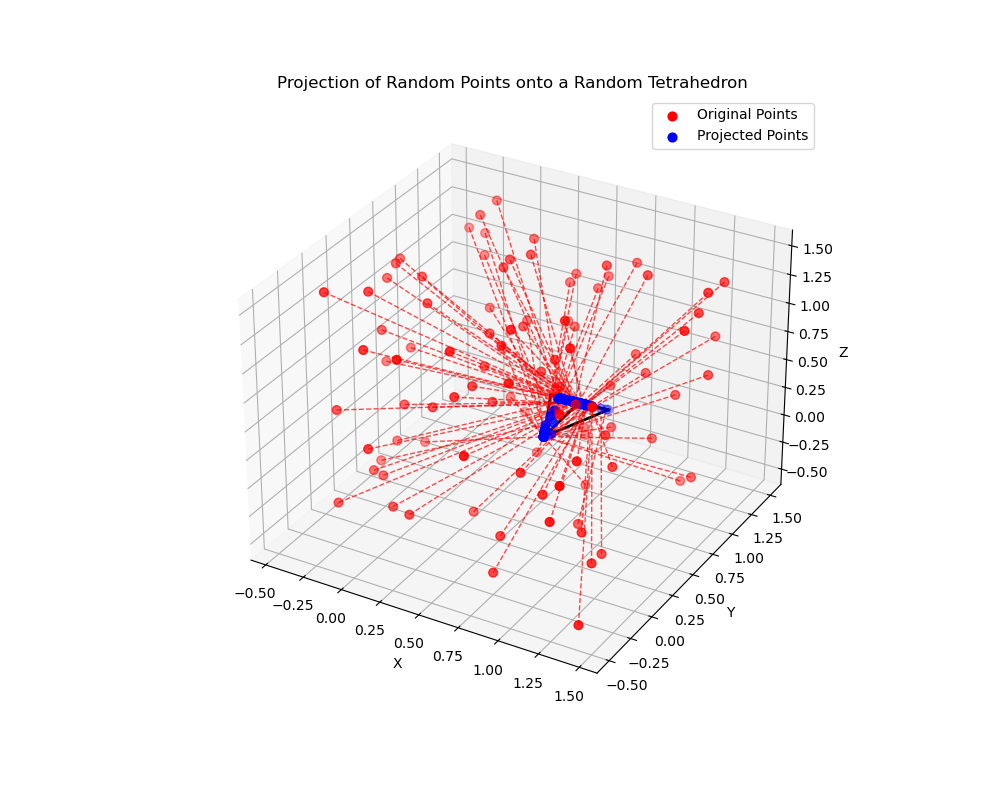

In [5]:
%matplotlib widget

import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def project_points_to_tetrahedra(points, tets):
    """
    Projects each point in `points` (shape (N, 3)) onto the corresponding tetrahedron in `tets` (shape (N, 4, 3))
    by simply renormalizing the barycentric coordinates.
    
    The full barycentrics for a tetrahedron with vertices v0, v1, v2, v3 are computed as:
      w0 = 1 - (x0+x1+x2)
      w1, w2, w3 = x0, x1, x2  (solved from T x = (p - v0), with T = [v1-v0, v2-v0, v3-v0])
    
    Then any negative values are clamped to zero and the 4 weights are renormalized to sum to 1.
    """
    N = points.shape[0]
    v0 = tets[:, 0, :]             # shape (N, 3)
    T = tets[:, 1:, :] - v0.unsqueeze(1)  # shape (N, 3, 3)
    
    # Solve for x corresponding to v1,v2,v3 weights: T x = (p - v0)
    p_minus_v0 = points - v0       # shape (N, 3)
    x = torch.linalg.solve(T, p_minus_v0.unsqueeze(2)).squeeze(2)  # shape (N, 3)
    
    # Compute full barycentrics: weight for v0 and for v1,v2,v3.
    w0 = 1 - x.sum(dim=1, keepdim=True)  # shape (N, 1)
    bary = torch.cat([w0, x], dim=1)      # shape (N, 4)
    
    # Renormalize: clamp negative values and renormalize so that sum=1.
    bary = torch.clamp(bary, min=0)
    bary = bary / bary.sum(dim=1, keepdim=True)
    
    # Reconstruct the point as the weighted sum of the tetrahedron vertices.
    p_proj = (bary.unsqueeze(2) * tets).sum(dim=1)
    return p_proj


def plot_tetrahedron_and_projections(tet, points, points_proj):
    """
    Plots a tetrahedron (given by tet: (4,3)) and the projection of a set of points onto it.
    Draws:
      - The tetrahedron's edges in black.
      - Original points in red.
      - Projected points in blue.
      - Dashed lines connecting each original point to its projection.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Draw the tetrahedron edges.
    # We list all edge pairs (6 edges for a tetrahedron).
    edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
    tet_np = tet.cpu().numpy()
    for i, j in edges:
        ax.plot([tet_np[i, 0], tet_np[j, 0]],
                [tet_np[i, 1], tet_np[j, 1]],
                [tet_np[i, 2], tet_np[j, 2]], 'k-', lw=2)
    
    # Plot the original and projected points.
    points_np = points.cpu().numpy()
    points_proj_np = points_proj.cpu().numpy()
    ax.scatter(points_np[:,0], points_np[:,1], points_np[:,2], color='red', s=40, label='Original Points')
    ax.scatter(points_proj_np[:,0], points_proj_np[:,1], points_proj_np[:,2], color='blue', s=40, label='Projected Points')
    
    # Draw lines connecting each original point to its projection.
    for p_orig, p_proj in zip(points_np, points_proj_np):
        ax.plot([p_orig[0], p_proj[0]],
                [p_orig[1], p_proj[1]],
                [p_orig[2], p_proj[2]], 'r--', lw=1, alpha=0.7)
    
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Projection of Random Points onto a Random Tetrahedron')
    plt.show()

if __name__ == '__main__':
    # Create a random tetrahedron by choosing 4 random vertices in [0,1]^3.
    tet = torch.rand(4, 3)
    # For our projection functions we need a batch of tetrahedra.
    # Here, we will use the same tetrahedron for all points.
    tets = tet.unsqueeze(0).repeat(100, 1, 1)  # shape (100, 4, 3)
    
    # Generate 100 random points in a larger region so some are outside the tetrahedron.
    points = torch.rand(100, 3) * 2 - 0.5  # roughly in [-0.5, 1.5]^3
    
    # Project the points onto the tetrahedron.
    points_proj = project_points_to_tetrahedra(points, tets)
    
    # Plot the tetrahedron and the projection results.
    plot_tetrahedron_and_projections(tet, points, points_proj)
